In [ ]:
## List of things to do

Jessica
- Data Cleaning 
- Arch diagram
-Sentiment 
https://www.youtube.com/watch?v=OcbDsbKeh_c&feature=youtu.be
    

Ishaan
- Scraping timeline to get tweet, add follower count 
- Introduction 
- KEywords + hashtags  
    

## Introduction
At present there are approximately 7.7 billion people in the world with atleast 3.5 billion of us online, implying that social media platforms are used by one-in-three people in the world. This sudden growth and adoption has transformed the way we find partners, access news information or even how we organize political change. Leveraging the power of social media is now more important than ever before. This project aims to optimize social media acticivity for our users by providing them suggestions based on data analysis. Specifically we hope to provide suggestions on the following: 
    1. What the best time to post on social media would be 
    2. What are some keywords to include in a tweet based on post category and trending tweets 
    3. What are some hashtags to include in a tweet based on post category and trending tweets 
    4. What is the current sentiment of the tweet the user has drafted
- Get Tweet Data 
- Predict Hashtags based on tweets (based on words and image)
- Predict captions if only images and links 
- Tag emootion of tweet content 

## Table of contents

## Architecture Diagram

<img src="imgs/1.png">

In [459]:
import requests
import urllib
import tweepy
import json
import csv
import pandas as pd
import numpy as np
from requests.auth import HTTPBasicAuth
import matplotlib.pyplot as plt
import re
import io
import time
from datetime import datetime

import nltk
from nltk.corpus import stopwords
from sklearn import preprocessing

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from webdriver_manager.chrome import ChromeDriverManager


## User Inputs tweets

In [456]:
user_name = "elonmusk"
orig_tweet = "Huge thanks to everyone who contributed ideas to Cybertruck. It’s better because of you! ♥️♥️♥️ #Tesla #Tech2020 #Design"
#Possible Categories are: Sports", "Politics", "Entertainment", "Education", "Technology", "Business"
orig_categories = ["Technology", "Business"] 

### Filtering, Preprocessing orignal Tweet

In [444]:
### replace emojis with descriptions of the emojis 
def de_emoji(tweet):
    new_tweet = ""
    emojis = []
    for character in tweet:
        try:
            character.encode("ascii")
            new_tweet += character
        except UnicodeEncodeError:
            replaced = unidecode(str(character))
            if replaced != '' and replaced !="[?]":
                new_tweet += replaced
            else:
                try:
                    emojis.append(unicodedata.name(character))
                except ValueError:
                     new_tweet += "[x]"
    return new_tweet, ",".join(emojis)
orig_tweet, orig_emojis = de_emoji(orig_tweet)
print("Tweet without emojis: "+orig_tweet+"\n")
print("Description of Emojis Used: "+orig_emojis)

Tweet without emojis: Huge thanks to everyone who contributed ideas to Cybertruck. It's better because of you!  #Tesla #Tech2020 #Design

Description of Emojis Used:BLACK HEART SUIT,VARIATION SELECTOR-16,BLACK HEART SUIT,VARIATION SELECTOR-16,BLACK HEART SUIT,VARIATION SELECTOR-16


In [458]:
lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()
def preprocess(tweet):
    
    ## lowercase
    lower_case = tweet.lower()
    lower_case= re.sub("'s", "", lower_case)
    
    ## removing apostrophes
    lower_case = lower_case.translate(str.maketrans('', '', "'"))
    lower_case = lower_case.translate(str.maketrans('', '', '"'))
    
    ## removing punctuation, only considering alphanumeric characters
    tweet_list = re.split('[^a-zA-Z0-9]', lower_case)
    
    str_list = [x for x in tweet_list if x != '']
    
    ## lemmatizing each word
    str_list = [lemmatizer.lemmatize(x) for x in str_list]
    
    ## removing stopwords
    str_list = [x for x in str_list if x not in stopwords.words('english')]
    
    hashtags, mentions = [], []
    ## Creating a seperate lists for tweet texts, hashtags(#twitter), mentions(@elonmusk, @carnegiemellon)
    for word in lower_case.split():
        word = word.strip()
        if len(word)>0 and word[0]=="@":
            mentions.append(word)
        if len(word)>0 and word[0]=="#":
            hashtags.append(word)
    return str_list, hashtags, mentions
clean_tweet, hashtags, mentions = preprocess(orig_tweet)
print(clean_tweet, hashtags, mentions)

['huge', 'thanks', 'everyone', 'contributed', 'idea', 'cybertruck', 'better', 'tesla', 'tech2020', 'design'] ['#tesla', '#tech2020', '#design'] []


## Web Scraping

In [511]:
## Scraping the user's timelines

def scraped_timeline(content, page, seen_tweets):
    soup = BeautifulSoup(page, "html.parser")
    timeline = soup.select('#timeline li.stream-item')
    for i, tweet in enumerate(timeline):
        count = tweet.select('span.ProfileTweet-actionCount')
        favs = 0.0
        retweets = 0.0
        for j in range(1, 3):  
            elem = count[j]
            val = elem.get_text().strip()
            num = ""
            i = 0
            while (i<len(val) and not(val[i]== " " or val[i]=="")):
                num+=val[i]
                i+=1
            if num!="":
                num = num.replace(',' , '')
                if num.isdigit():
                    if j==1:
                        retweets = int(num)
                    elif j==2:
                        favs = int(num)
        tweet_text = tweet.select('p.tweet-text')[0].get_text()
        tweet_time = tweet.select('a.tweet-timestamp')
        for elem in tweet_time:
            time = (elem.get('title'))   
        if tweet_text not in seen_tweets:
            seen_tweets.add(tweet.text)
            text, emojis = deEmojify(tweet_text)
            content["created_at"].append(time)
            content["text"].append(text)
            content["emojis"].append(emojis)
            content["favorite_count"].append(favs)
            content["retweet_count"].append(retweets)
            
    return    

In [512]:
def create_timeline_df(user_name, no_of_pagedowns=1):
    driver = webdriver.Chrome(ChromeDriverManager().install())
    browser = driver
    url = "https://twitter.com/" + user_name
    browser.get(url)
    time.sleep(1)
    elem = browser.find_element_by_tag_name("body")
    while no_of_pagedowns>=0:
        elem.send_keys(Keys.PAGE_DOWN)
        time.sleep(0.2)
        no_of_pagedowns-=1

    content = {"created_at":[], "text":[], "emojis":[], "favorite_count":[], "retweet_count":[]}
    seen_tweets = set()
    html_source = scraped_timeline(content, browser.page_source, seen_tweets)
    user_timeline_df = pd.DataFrame.from_dict(content)
    return user_timeline_df

In [514]:
user_timeline_df = create_timeline_df(user_name)
clean_tweet, hashtags, mentions, emojis = [], [], [], []
for tweet in user_timeline_df['text']:
    tweet, emoji = de_emoji(tweet)
    tweet, hashtag, mention = preprocess(tweet)
    clean_tweet.append(tweet)
    hashtags.append(hashtag)
    mentions.append(mention)
    emojis.append(emoji)
user_timeline_df['text'] = clean_tweet
user_timeline_df['hashtags'] = hashtags
user_timeline_df['mentions'] = mentions
user_timeline_df['emojis'] = emojis
user_timeline_df


Looking for [chromedriver 78.0.3904.105 mac64] driver in cache 
File found in cache by path [/Users/ishaanjaffer/.wdm/drivers/chromedriver/78.0.3904.105/mac64/chromedriver]


,created_at,text,emojis,favorite_count,retweet_count,hashtags,mentions
0,10:15 AM - 9 Dec 2019,"[tesla, virtual, power, plant, rescue, grid, c...",,7043,970,[],[]
1,2:09 AM - 8 Dec 2019,"[capture, confirmed, 19, flight, space, statio...",,20434,1839,[],"[@space_station,]"
2,3:56 PM - 7 Dec 2019,"[huge, thanks, everyone, contributed, idea, cy...",,154655,5459,[],[]
3,12:55 PM - 7 Dec 2019,"[falcon, 9, land, course, still, love, dronesh...",,52502,5094,[],[]
4,12:19 PM - 7 Dec 2019,"[speed, solves, everythingpic, twitter, com, d...",,238026,30456,[],[]
5,8:46 PM - 6 Dec 2019,"[super, strong, roof, generates, clean, energy...",,45954,3872,[],[]
6,9:43 AM - 5 Dec 2019,"[dragon, solar, array, deployed, way, internat...",,19199,2227,[],[@space_station]
7,9:30 AM - 5 Dec 2019,"[liftoff, pic, twitter, com, 4w7otmnay1]",,39679,5050,[],[]
8,9:14 AM - 5 Dec 2019,"[webcast, falcon, 9, launch, livehttps, twitte...",,13443,3281,[],[]
9,6:27 AM - 5 Dec 2019,"[falcon, 9, launch, dragon, targeted, 12, 29, ...",,11321,1458,[],[]


## Hashtag 

In [4]:
# Find most popular hashtags 

## Time 

In [307]:
#from retrying import retry

#@retry(wait_exponential_multiplier=1000, wait_exponential_max=10000)
def get_tweets():
    consumer_key = "jKh08dfgDeTPztN1rzCpTG7Ub"
    consumer_secret = "piCHq08QogdkccQjQ4w74ejfNZl0ZLJeN5QDfkyNKp1AUG1nL8"
    access_token = "968209315285946373-kB1go0AZDLjgR3uw8D04fkekvLNGrM2"
    access_secret = "49zXLZmjYPdVwIufciUGgM5vtn9YtLD4YehU6pydKCWZY"
    
    try:
        print("hello")
        auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
        auth.set_access_token(access_token, access_secret)
        api = tweepy.API(auth, wait_on_rate_limit=True)

        csvFile = open('final-project-tweets.csv', 'a')

        #Use csv writer
        csvWriter = csv.writer(csvFile)
        csvWriter.writerow(["category", "screen_name", "created_at", "text", "emojis", "favorite_count", "retweet_count", "follower_count"])
        categories = ["Sports", "Politics", "Entertainment", "Education", "Technology", "Business"]
        dates = ["11-27", "11-28", "11-29", "11-30", "11-31", "12-1", "12-2", "12-3", "12-4"]
        for category in categories:
            for date in range(len(dates)-1):
                for tweet in tweepy.Cursor(api.search,q = category,since = "2019-"+dates[date],until = "2019-"+dates[date+1],lang = "en", result_type = 'popular').items():
                    text, emojis = deEmojify(tweet.text)
                    csvWriter.writerow([category, tweet.user.screen_name, tweet.created_at, text, emojis, tweet.favorite_count, tweet.retweet_count, tweet.user.followers_count])
                    print(category, tweet.user.screen_name, tweet.created_at, text, emojis, tweet.favorite_count, tweet.retweet_count, tweet.user.followers_count) #, tweet.get_tweet_sentiment(tweet.test))
                    time.sleep(.200)
                    #print (tweet.user.screen_name, tweet.created_at, tweet.text)
        csvFile.close()
    except tweepy.error.TweepError:
        raise
        
get_tweets()

hello
Sports NFL 2019-12-01 19:19:43 PUNTER TO KICKER TOUCHDOWN!

The @MiamiDolphins pull off the trickery! #PHIvsMIA

: FOX
: NFL app // Yahoo Sports... https://t.co/0xpJSZFo5B TELEVISION,MOBILE PHONE 12250 2897 24816788
Sports NFL 2019-12-01 18:10:14 The @49ers score first!

@JimmyG_10 to Deebo Samuel for 33 yards on 4th and 2! #GoNiners

: #SFvsBAL on FOX
: NFL... https://t.co/b5NYWSaLyB TELEVISION,MOBILE PHONE 2443 600 24816788
Sports NFL 2019-12-01 21:48:06 ONE-HANDED. FULL EXTENSION.

@SuttonCourtland hauls in @DrewLock23's first career TD pass! #LACvsDEN 

: CBS
: NF... https://t.co/bv4KVgiNP2 TELEVISION,MOBILE PHONE 1327 368 24816788
Sports NFL 2019-12-01 18:14:42 Jarvis just did that 

Sideline grab of the year?! @God_Son80

: #CLEvsPIT on CBS
: NFL app // Yahoo Sports app... https://t.co/2cz5pRctZV FACE SCREAMING IN FEAR,TELEVISION,MOBILE PHONE 1508 289 24816788
Sports NFL 2019-12-01 18:46:10 .@DeVanteParker11, OH MY!  #FinsUp

: #PHIvsMIA on FOX
: NFL app // Yahoo Sports app

Sports smillerdegnan 2019-12-02 00:11:21 The fans are livid. But worse than that, they soon might not care.

NEW SUNDAY NIGHT: The New Miami's reality: 'hur... https://t.co/vIw3089YSZ  114 24 20043
Sports rameshlaus 2019-12-03 16:58:33 #YahooIndia Most Searched Sports Personality of 2019

1. @msdhoni 

2. @ImRo45 

3. @imVkohli  11750 2573 432915
Sports NFL 2019-12-03 02:15:19 One of the craziest Pick-6s you'll ever see.

Anthony Harris to the  for 6[?]! @HOOSDatDude #SKOL

: #MINvsSEA on... https://t.co/ravKpUGbRs HOUSE BUILDING,COMBINING ENCLOSING KEYCAP,TELEVISION 2282 585 24816788
Sports UKLabour 2019-12-03 16:30:00 These 5 employers have exploited, ripped off and dehumanised workers in the UK

Amazon
Sports Direct
ISS
Asda
... https://t.co/U747yVGQNz PERSONAL COMPUTER,T-SHIRT,HOSPITAL,SHOPPING BAGS,TAXI 1294 699 789795
Sports ArvindKejriwal 2019-12-03 12:14:59 We passed Bills in Del Assembly in last 2 days to set up Del Skill Univ and Del Sports Univ. This will channel yout... htt

Politics GOPChairwoman 2019-12-02 02:07:22 Whether it's the Russia hoax or the Ukraine hoax, it's all politics for Jerry Nadler.

As @DevinNunes points out, "... https://t.co/XjwMxuR0sd  4968 1916 432500
Politics thecjpearson 2019-12-02 20:25:41 Our politics is broken. Our Congress is non-reflective of the people. 

We need term limits. Now. 

It's time to clean house.  9065 2116 321423
Politics Nigel_Farage 2019-12-02 07:08:57 What we saw last night is there is no desire to change anything. 

So we need to get some strong, new and fresh voi... https://t.co/N6VgPcselP  8538 2707 1457949
Politics ABC 2019-12-02 11:02:06 "Give me a hug": 2020 candidate Elizabeth Warren shares emotional moment with young voter over struggle for accepta... https://t.co/ADdgaLi66a  15458 2862 14716078
Politics EvanMcMullin 2019-12-02 00:49:30 Okay, well, if neither Trump nor his lawyers will participate in a public hearing about impeachment and how it may... https://t.co/n1yiK8uG6T  9068 2915 483554
Politic

Politics CNN 2019-12-03 00:15:07 George Conway, the husband of White House counselor Kellyanne Conway, has escalated his criticism of President Trum... https://t.co/HJCOeGhkoE  2013 366 43781055
Politics ThisWeekABC 2019-12-03 00:01:02 "My heart drops to my stomach when I realize he has tweeted about me again. The president of the United States is c... https://t.co/BoEkPd25D3  674 221 182436
Politics CNN 2019-12-03 00:30:07 Pence pushed Trump to fire Flynn. Cohen was told not to contradict Trump. Here's what is in the newly released note... https://t.co/HFkXPrj3uX  445 185 43781055
Politics CNN 2019-12-03 00:00:06 A federal appeals court has rejected an emergency bid from the Trump administration to move forward next week with... https://t.co/NccVwovNFf  188 90 43781055
Politics jayrosen_nyu 2019-12-03 00:31:15 Many of the problems the national press is having today stem from a failure of imagination. More specifically, the... https://t.co/E0dRmauMC2  203 91 259502
Politics RossBarkan 

Entertainment allkpop 2019-12-02 00:27:22 Pledis Entertainment clarifies the official spelling of ARON's name
https://t.co/N9xM9HmpCJ https://t.co/roc05kujOO  676 100 5393851
Entertainment Essence 2019-12-02 00:30:11 "She's just a super mom, really." https://t.co/JDZhY1XlAr  436 44 384747
Entertainment IWriteAllDay_ 2019-12-03 20:31:01 Drake should not be texting Millie, Billie, or your cousin Lily. Let's fight!

https://t.co/EOBTPihAly  35275 8238 60690
Entertainment Independent 2019-12-03 11:57:28 Dua Lipa urges followers to vote Labour in general election https://t.co/13MiQxqFaF  6141 1168 2953591
Entertainment KojiPro2015_EN 2019-12-03 07:10:50 Congratulations for the 25th Playstation Anniversary! 
Went to the Sony Interactive Entertainment employee cafeteri... https://t.co/kkc8NFPWkW  3278 515 310747
Entertainment BBCNews 2019-12-03 21:58:43 "At a time of political division in Britain and conflict in much of the world, the artists wanted... to make a stro... https://t.co/yQw4B4Epi

Education Amelia_Womack 2019-12-01 20:13:42 I think @sianberry only got three seconds on Trident.

To be clear - Trident belongs in the dustbins of history and... https://t.co/YzvqLFDmnL  193 50 48061
Education UNESCO 2019-12-01 22:15:07 A lack of
 
teaching materials
[?]time in the schedule
sufficient monitoring
 
are major barriers to provide Compre... https://t.co/UHsjV0tV1w BOOKS,BOOKMARK TABS 57 23 3130413
Education ANI 2019-12-01 23:08:01 Board of Secondary Education Manipur has permitted Issac Paulallungmuan to appear in the class 10 state boards exam... https://t.co/riVE97fBVT  110 33 3266653
Education arthur_affect 2019-12-01 21:55:07 The concept of student loans is a very complicated, badly designed, and inevitably unfair way to say "People who ge... https://t.co/m3zF9371Fq  119 28 40264
Education RepRoKhanna 2019-12-01 17:55:00 The more we spend on overpriced drugs, the less we can spend on public education, infrastructure, and job creation.... https://t.co/E9gULRael5  123 4

Technology TheEconomist 2019-12-01 18:45:05 In principle, eliminating HIV is possible with existing technology  https://t.co/iMd9D1vjQc  329 164 24189913
Technology JDScholten 2019-12-01 21:47:00 More than anything else, #IA04 exports our kids who are looking for better opportunities. 

That's why we need to i... https://t.co/JgWsF23OX3  265 79 124305
Technology EdwardTHardy 2019-12-01 23:00:00 Reminder: Rick Perry's time as Energy Secretary was not scandal free

He created the Office for Artificial Intellig... https://t.co/YM8bXnnb8O  241 89 115143
Technology rebeccagrants 2019-12-01 23:45:29 Remember when Hoverboards were all the rage?
Well @HoverHelmets have perfected the technology and are this year's h... https://t.co/tCUJxuGYHV  320 32 152749
Technology ABC 2019-12-01 23:15:32 The world has gotten hotter, lost trillions of tons of ice and suffered more weather disasters since climate negoti... https://t.co/WUlHPivrGY  279 166 14716080
Technology TheWestBlock 2019-12-01 22:20:11 "

Technology Huawei 2019-12-03 17:31:41 British Deaf Association has a deep understanding of the deaf communities' problems and Huawei of technology. It's... https://t.co/Z8syw5XW9k  3671 268 1073654
Technology AdamMKaufman 2019-12-03 12:24:16 No joke, this simple scroll was one of the most exhilarating things you could experience as a kid 30 years ago. For... https://t.co/BDeKhnjsl5  1645 198 31594
Technology Omkar_Raii 2019-12-03 02:18:20 The Government planning to create 5 crore more jobs in addition to the existing 11 cr. employment in #MSME sector &amp;... https://t.co/5BZNQ4P0E4  234 251 11022
Technology nytimes 2019-12-03 04:00:09 The Trump administration said that a new French tax that hit American technology companies discriminated against th... https://t.co/ak76L7Sh93  237 138 44609608
Technology upsystem 2019-12-03 08:51:47 National Scientist Edgardo Gomez has passed away, the Department of Science and Technology announced on Tuesday.

T... https://t.co/37MfrIVPHu  460 80 1718

Business jeremycorbyn 2019-12-02 14:03:55 Let's take back control of our railways to bring down fares and make them work for passengers, not profiteers.

https://t.co/AW4ifXOKfN  11588 2915 2278216
Business gabcake 2019-12-02 17:55:41 10 years ago (photo on the left) had a secret school business where i would find answer keys to tests $50/ person.... https://t.co/oyMLUxSKeN  7062 489 1267869
Business cobbo3 2019-12-02 14:47:08 Samoa shuts down entire govt after measles outbreak kills 53. Measles has killed 5,000+ in DR Congo &amp; it's business... https://t.co/C6ln8kqnde  340 268 394345
Business JhaSanjay 2019-12-02 04:16:41 Which other Indian Big Business type has questioned the government like #RahulBajaj, who has asked why is... https://t.co/qtRg4We6Bo  1674 409 443565
Business UKLabour 2019-12-02 08:42:45 Labour will cut rail fares by 33% from January 2020.

Taking back control of our railways is the only way to bring... https://t.co/6NaJbmur0C  2575 1029 789799
Business lilduval 2

Business JonErlichman 2019-12-03 00:17:13 VC investments in space startups:
 
2019: $5 billion (first 9 months)
2018: $2.97 billion
2017: $4.6 billion
2016:... https://t.co/0XzW6dUvkj  337 120 113496
Business RobertMaguire_ 2019-12-03 00:56:46 The administration headed by a president who still owns and profits from a winery is considering a 100 percent tarr... https://t.co/lbUSO2SF5f  136 88 60236
Business foe_us 2019-12-03 00:00:04 Emails show that chemical giant @Bayer discussed giving a media nonprofit money in exchange for positive reporting... https://t.co/QF152k5E7D  22 22 169634


In [520]:
data = pd.read_csv("final-project-tweets.csv") 
#print(len(data))
data.head()
#print(data)

,category,screen_name,created_at,text,emojis,favorite_count,retweet_count,follower_count
0,Sports,NFL,12/1/19 19:19,PUNTER TO KICKER TOUCHDOWN!\r\rThe @MiamiDolph...,"TELEVISION,MOBILE PHONE",12250,2897,24816788
1,Sports,NFL,12/1/19 18:10,The @49ers score first!\r\r@JimmyG_10 to Deebo...,"TELEVISION,MOBILE PHONE",2443,600,24816788
2,Sports,NFL,12/1/19 21:48,ONE-HANDED. FULL EXTENSION.\r\r@SuttonCourtlan...,"TELEVISION,MOBILE PHONE",1327,368,24816788
3,Sports,NFL,12/1/19 18:14,Jarvis just did that \r\rSideline grab of the ...,"FACE SCREAMING IN FEAR,TELEVISION,MOBILE PHONE",1508,289,24816788
4,Sports,NFL,12/1/19 18:46,".@DeVanteParker11, OH MY! #FinsUp\r\r: #PHIvs...","FACE SCREAMING IN FEAR,TELEVISION,MOBILE PHONE",1296,298,24816788


In [521]:
## Clean all tweets 
def clean_tweets(df):
    clean_tweet, hashtags, mentions, emojis = [], [], [], []
    for tweet in df['text']:
        tweet, emoji = de_emoji(tweet)
        tweet, hashtag, mention = preprocess(tweet)
        clean_tweet.append(tweet)
        hashtags.append(hashtag)
        mentions.append(mention)
        emojis.append(emoji)
    df['text'] = clean_tweet
    df['hashtags'] = hashtags
    df['mentions'] = mentions
    
    return df
data = clean_tweets(data)

In [522]:
data

,category,screen_name,created_at,text,emojis,favorite_count,retweet_count,follower_count,hashtags,mentions
0,Sports,NFL,12/1/19 19:19,"[punter, kicker, touchdown, miamidolphins, pul...","TELEVISION,MOBILE PHONE",12250,2897,24816788,[#phivsmia],[@miamidolphins]
1,Sports,NFL,12/1/19 18:10,"[49ers, score, first, jimmyg, 10, deebo, samue...","TELEVISION,MOBILE PHONE",2443,600,24816788,"[#goniners, #sfvsbal]","[@49ers, @jimmyg_10]"
2,Sports,NFL,12/1/19 21:48,"[one, handed, full, extension, suttoncourtland...","TELEVISION,MOBILE PHONE",1327,368,24816788,[#lacvsden],"[@suttoncourtland, @drewlock23]"
3,Sports,NFL,12/1/19 18:14,"[jarvis, sideline, grab, year, god, son80, cle...","FACE SCREAMING IN FEAR,TELEVISION,MOBILE PHONE",1508,289,24816788,[#clevspit],[@god_son80]
4,Sports,NFL,12/1/19 18:46,"[devanteparker11, oh, finsup, phivsmia, fox, n...","FACE SCREAMING IN FEAR,TELEVISION,MOBILE PHONE",1296,298,24816788,"[#finsup, #phivsmia]",[]
...,...,...,...,...,...,...,...,...,...,...
380,Business,business,12/3/19 2:38,"[china, hint, u, blacklist, unreliable, entity...",NaN,51,52,5738276,[],[]
381,Business,jaketapper,12/3/19 2:03,"[la, time, jury, order, billionaire, alki, dav...",NaN,436,131,2203263,[],[]
382,Business,JonErlichman,12/3/19 0:17,"[vc, investment, space, startup, 2019, 5, bill...",NaN,337,120,113496,[],[]
383,Business,RobertMaguire_,12/3/19 0:56,"[administration, headed, president, still, own...",NaN,136,88,60236,[],[]


In [523]:
## creating a ranking column
data['ranking'] = (data['retweet_count'] + data['favorite_count'])/data['follower_count']
## normalising the ranking columns
x = data[['ranking']].values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
data['ranking'] = 100*pd.DataFrame(x_scaled)

In [415]:
text_data = data['text']
for row in text_data:
    tokens = str(row).split(",")
    new_tokens = []
    for elem in tokens:
        if elem.isalpha():
            new_tokens.append(elem)
    print(new_tokens)
    

['PUNTER', 'TO', 'KICKER', 'The', 'pull', 'FOX', 'NFL', 'app', 'Yahoo']
['The', 'score', 'Deebo', 'Samuel', 'yards', 'FOX']
['FULL', 'hauls', 'first', 'career', 'TD', 'CBS']
['Jarvis', 'Sideline', 'grab', 'CBS', 'NFL', 'app', 'Yahoo', 'Sports']
['OH', 'FOX', 'NFL', 'app', 'Yahoo', 'Sports', 'app', 'Watch', 'free']
['That', 'hangs', 'unreal', 'TD', 'CBS', 'NFL', 'app']
['FOX', 'NFL', 'app', 'Yahoo', 'Sports', 'app', 'Watch', 'free']
['Their', 'second', 'TD', 'connection', 'first']
['rolls', 'hits', 'take', 'FOX', 'NFL', 'app']
['rookie', 'Taylor', 'Rapp', 'FOX', 'NFL', 'app', 'Yahoo', 'Sports', 'app', 'Watch', 'free']
['What', 'play', 'Marcell', 'FOX', 'NFL', 'app', 'Yahoo', 'Sports', 'app', 'Watch', 'free']
['Derrius', 'Guice', 'first', 'career', 'rushing', 'CBS', 'NFL', 'app', 'Yahoo']
['rushing', 'CBS', 'NFL', 'app', 'Yahoo']
['rookie', 'TO', 'THE', 'CBS', 'NFL', 'app', 'Yahoo', 'Sports']
['Today', 'New', 'York', 'Giants', 'L', 'straight', 'Jets', 'L', 'winning', 'Nets', 'L']
['FYI',

['Progressives', 'decry', 'fake', 'ICE', 'university', 'turns', 'created', 'President', 'Obama', 'via']
['Neither', 'President', 'attorneys', 'participate', 'House', 'Judiciary', 'impeachment', 'hearing']
['Trump', 'lawyers', 'participate', 'impeachment', 'hearing', 'House', 'Judiciary']
['Black', 'Friday', 'Firearm', 'Background', 'Checks', 'Rank', 'Highest', 'History']
['Neither', 'President', 'Trump', 'attorneys', 'participate', 'House', 'Judiciary', 'Committee']
['John', 'Kennedy', 'early', 'Sunday', 'said', 'impeachment', 'hearings', 'rigged', 'carnival', 'ring']
['Worry', 'rises', 'military', 'President']
['A', 'recurring', 'pattern', 'among', 'voters', 'I', 'speak', 'agreement', 'principle', 'programs', 'like', 'Medicare']
['Department', 'Homeland', 'Security', 'investigators', 'track', 'fraudulent', 'transactions', 'confiscated']
['House', 'Speaker', 'Nancy', 'Pelosi', 'lead', 'group', 'Democratic', 'lawmakers', 'UN', 'climate', 'change']
['Trump', 'missed', 'deadline', 'tell',

['I', 'We', 'entertainment', 'options', 'ever', 'Why', 'would', 'I', 'choose', 'give', 'money', 'people']
['The', 'cat', 'little', 'tongue', 'stole', 'hearts', 'internet', 'died', 'age', 'The', 'news', 'announced']
['Tom', 'Kiefer', 'began', 'collecting', 'items', 'seized', 'migrants', 'working', 'janitor', 'Customs']
['LA', 'Jury', 'orders', 'billionaire', 'Alki', 'David', 'pay', 'million', 'punitive', 'damages', 'sexual', 'battery', 'suit']
['The', 'Border', 'Patrol', 'trashed', 'possessions', 'janitor', 'recovered', 'sought', 'give', 'dignity']
['Historical', 'Drama', 'Will', 'Be', 'Grander', 'Than', 'You', 'Actually', 'Thought']
['next', 'comic', 'goes', 'floors', 'next', 'year']
['Just', 'want', 'set', 'facts', 'I', 'surgery', 'Very', 'likely', 'person', 'never', 'actually', 'met']
['toyed', 'lives', 'emotions', 'To', 'fair', 'Chuck', 'told', 'boys', 'everything', 'The']
['ATF', 'Electric', 'Entertainment', 'TVDRAMA']
['asking', 'us', 'set', 'new', 'million', 'million', 'symbolic'

['facial', 'recognition', 'rollout', 'reaches', 'mobile', 'phones', 'shops', 'homes']
['O', 'Group', 'premiers', 'band', 'together', 'develop', 'small', 'modular', 'nuclear', 'reactors', 'one', 'best', 'hopes']
['The', 'respects', 'right', 'set', 'technology', 'But', 'friendships', 'alliances']
['Naguib', 'Sawiris', 'Executive', 'Chairman', 'Orascom', 'Telecom', 'Media', 'Technology', 'calls', 'Prime', 'Minister']
['China', 'plans', 'accomplish', 'solar', 'power', 'station', 'according', 'China']
['How', 'Technology', 'Will', 'Impact', 'Banking', 'Industry', 'transactions']
['Today', 'I', 'found', 'Kodak', 'PhotoCD', 'visit', 'late', 'It', 'got', 'thinking']
['From', 'smart', 'doorbells', 'watching', 'Halloween', 'daily', 'school', 'monitoring', 'children']
['real', 'concern', 'use', 'Huawei']
['This', 'democracies', 'need', 'think', 'whether', 'proposed', 'approaches', 'information', 'manipulation', 'actually']
['The', 'air', 'industry', 'knows', 'carbon', 'footprint', 'problem']
['Ho

['leads', 'Seahawks', 'past', 'Vikings', 'top', 'NFC', 'West', 'Seattle', 'takes', 'care']
['So', 'weird', 'America', 'First', 'isolationism', 'always', 'slides', 'actively', 'siding']
['big', 'consulting', 'firms', 'really', 'suffer', 'enough', 'blowback', 'titanically', 'evil', 'stuff', 'core']
['place', 'world', 'regime', 'blinding', 'people', 'doctors', 'made', 'business']
['China', 'says', 'suspend', 'Navy', 'visits', 'Hong', 'Kong', 'sanction', 'range', 'American']
['small', 'business', 'owners', 'approve', 'President', 'handling', 'job', 'according', 'recently']
['Donald', 'Trump', 'made', 'astounding', 'promotional', 'visits', 'properties', 'president']
['Promises', 'MADE', 'promises']
['long', 'maintained', 'business', 'deals', 'Cohen', 'told', 'FBI', 'Trump', 'knew']
['More', 'business', 'handled', 'NEXT']
['The', 'economics', 'Christian', 'As', 'Christians', 'ventured', 'money', 'lending', 'business', 'created']
['tweet', 'inform', 'Knicks', 'score', 'please', 'bother', 'was

In [366]:
data

,category,screen_name,created_at,text,emojis,favorite_count,retweet_count,follower_count,hashtags,mentions,links,ranking
0,Sports,NFL,2019-12-01 19:19:43,"PUNTER,TO,KICKER,TOUCHDOWN!,The,pull,trickery!...","TELEVISION,MOBILE PHONE",12250,2897,24816788,#PHIvsMIA,@MiamiDolphins,https://t.co/0xpJSZFo5B,0.021856
1,Sports,NFL,2019-12-01 18:10:14,"The,score,first!,Deebo,Samuel,33,yards,4th,2!,...","TELEVISION,MOBILE PHONE",2443,600,24816788,"#GoNiners,#SFvsBAL","@49ers,@JimmyG_10",https://t.co/b5NYWSaLyB,0.004296
2,Sports,NFL,2019-12-01 21:48:06,"ONE-HANDED.,FULL,EXTENSION.,hauls,first,career...","TELEVISION,MOBILE PHONE",1327,368,24816788,#LACvsDEN,"@SuttonCourtland,@DrewLock23's",https://t.co/bv4KVgiNP2,0.002340
3,Sports,NFL,2019-12-01 18:14:42,"Jarvis,Sideline,grab,year?!,:,CBS,:,NFL,app,//...","FACE SCREAMING IN FEAR,TELEVISION,MOBILE PHONE",1508,289,24816788,#CLEvsPIT,@God_Son80,https://t.co/2cz5pRctZV,0.002488
4,Sports,NFL,2019-12-01 18:46:10,".@DeVanteParker11,,OH,MY!,:,FOX,:,NFL,app,//,Y...","FACE SCREAMING IN FEAR,TELEVISION,MOBILE PHONE",1296,298,24816788,"#FinsUp,#PHIvsMIA",,https://t.co/m82mylCR1g,0.002193
...,...,...,...,...,...,...,...,...,...,...,...,...
380,Business,business,2019-12-03 02:38:21,"China,hints,U.S.,blacklist,""unreliable,entitie...",NaN,51,52,5738276,,,https://t.co/sqAGvlitJx,0.000527
381,Business,jaketapper,2019-12-03 02:03:41,"LA,Times:,Jury,orders,billionaire,Alki,David,p...",NaN,436,131,2203263,,,https://t.co/KF1zGHbmrY,0.009146
382,Business,JonErlichman,2019-12-03 00:17:13,"VC,investments,space,startups:,2019:,$5,billio...",NaN,337,120,113496,,,https://t.co/0XzW6dUvkj,0.144851
383,Business,RobertMaguire_,2019-12-03 00:56:46,"The,administration,headed,president,still,owns...",NaN,136,88,60236,,,https://t.co/lbUSO2SF5f,0.133766


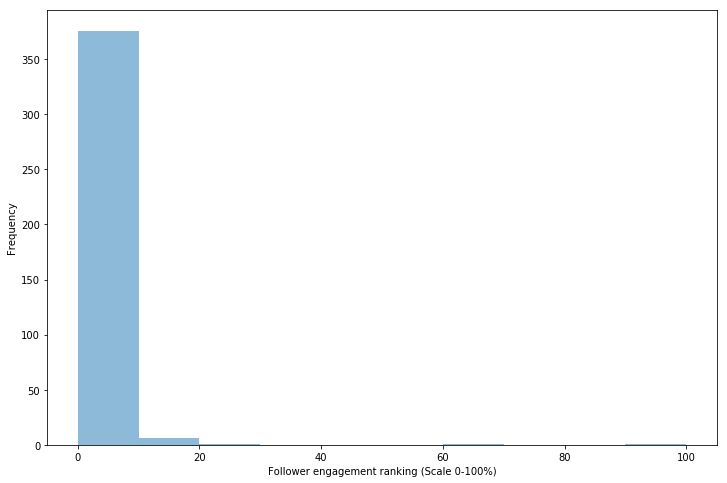

In [401]:
fig = plt.figure(figsize = (12,8))
ax = fig.gca()
ax.set_xlabel("Follower engagement ranking (Scale 0-100%)")
ax.set_ylabel("Number of posts with ranking")
data['ranking'].plot.hist(bins=10, alpha=0.5, ax=ax)

## Considering Relevancy of a tweet

## Time tweet was posted since current day & time
This accounts for the fact that social media trends today are not the same as they were last week or last year. We will calculate the number of days it has been since the tweet was posted

In [408]:
now = datetime.now()

diff = []
data['created_at'] = pd.to_datetime(data['created_at'])
time_diff = (now - data['created_at'])
for elem in time_diff:
    diff.append(elem.total_seconds())
data['num_seconds'] = diff
print(data)

     category     screen_name          created_at  \
0      Sports             NFL 2019-12-01 19:19:43   
1      Sports             NFL 2019-12-01 18:10:14   
2      Sports             NFL 2019-12-01 21:48:06   
3      Sports             NFL 2019-12-01 18:14:42   
4      Sports             NFL 2019-12-01 18:46:10   
..        ...             ...                 ...   
380  Business        business 2019-12-03 02:38:21   
381  Business      jaketapper 2019-12-03 02:03:41   
382  Business    JonErlichman 2019-12-03 00:17:13   
383  Business  RobertMaguire_ 2019-12-03 00:56:46   
384  Business          foe_us 2019-12-03 00:00:04   

                                                  text  \
0    PUNTER,TO,KICKER,TOUCHDOWN!,The,pull,trickery!...   
1    The,score,first!,Deebo,Samuel,33,yards,4th,2!,...   
2    ONE-HANDED.,FULL,EXTENSION.,hauls,first,career...   
3    Jarvis,Sideline,grab,year?!,:,CBS,:,NFL,app,//...   
4    .@DeVanteParker11,,OH,MY!,:,FOX,:,NFL,app,//,Y...   
..             

## Best Hashtag

In [423]:
relevant_data = data[['hashtags','ranking', 'num_seconds']]

## drop tweets/rows having no hashtags
relevant_data['hashtags'].replace('', np.nan, inplace=True)
relevant_data.dropna(subset=['hashtags'], inplace=True)
print(relevant_data)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


               hashtags    ranking    num_seconds
0             #PHIvsMIA   0.021856  773282.585684
1    #GoNiners,#SFvsBAL   0.004296  777451.585684
2             #LACvsDEN   0.002340  764379.585684
3             #CLEvsPIT   0.002488  777183.585684
4     #FinsUp,#PHIvsMIA   0.002193  775295.585684
..                  ...        ...            ...
362              #China   1.531880  593801.585684
363                #CCP  10.795672  614890.585684
367            #Kashmir   0.308400  643567.585684
373               #RAW.   0.004274  661703.585684
377         #TeamBlake.   0.003580  668265.585684

[70 rows x 3 columns]


AttributeError: 'Series' object has no attribute 'arg_max'

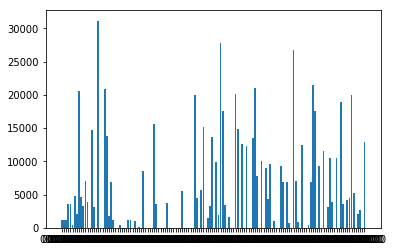

In [99]:
#sum_grpr.index.astype('timedelta64[s]')
sum_grpr['tmpstmp'] = sum_grpr['tmpstmp'].dt.time.astype(str)
plt.bar(sum_grpr['tmpstmp'],height=sum_grpr['avg_favorites'])
#max_time = sum_grpr['avg_favorites'].arg_max()
#print(sum_grpr[max_time])

In [98]:
#print(data)
groups = data.groupby(['category'])
#for key, value in groups:
    #print(key, value)
category = groups.get_group("Politics")
time_grpr = category.groupby(pd.Grouper(key='created_at', freq='10min'))
#groups = groups.get_group("Politics").groupby(pd.Grouper(key='created_at', freq='10min'))
#for key, value in time_grpr:
    #print(key, value)
#time_grpr_retweet = groups['retweet_count','favorite_count'].sum()
#print(time_grpr_retweet)
#time_grpr_retweet['created'] = time_grpr_retweet.index"""
sum_grpr = time_grpr['favorite_count', 'retweet_count'].sum()
sum_grpr['tmpstmp'] = sum_grpr.index
sum_grpr['count'] = time_grpr['text'].count()
#print(sum_grpr)
sum_grpr['avg_favorites'] = sum_grpr['favorite_count']/sum_grpr['count']
sum_grpr['avg_retweets'] = sum_grpr['retweet_count']/sum_grpr['count']
sum_grpr = sum_grpr.fillna(0)
print(sum_grpr)

                     favorite_count  retweet_count             tmpstmp  count  \
created_at                                                                      
2019-12-04 00:00:00           24824           6428 2019-12-04 00:00:00     21   
2019-12-04 00:10:00           15866           5221 2019-12-04 00:10:00     14   
2019-12-04 00:20:00           18155           4347 2019-12-04 00:20:00     15   
2019-12-04 00:30:00           31847           9317 2019-12-04 00:30:00      9   
2019-12-04 00:40:00           21251           5779 2019-12-04 00:40:00      6   
2019-12-04 00:50:00            1970           1260 2019-12-04 00:50:00      4   
2019-12-04 01:00:00           33396           9330 2019-12-04 01:00:00      7   
2019-12-04 01:10:00            6358            919 2019-12-04 01:10:00      3   
2019-12-04 01:20:00           61680          16946 2019-12-04 01:20:00      3   
2019-12-04 01:30:00           18248           6177 2019-12-04 01:30:00      4   
2019-12-04 01:40:00         